In [97]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from firthlogist import FirthLogisticRegression


class QLearningModule:
    def __init__(self, lr, rl_temp, n_states, n_actions, q0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = lr
        self.rl_temp = rl_temp
        self.q = np.ones((n_states, n_actions)) * q0
    
    def rl_learn(self, s, a, r):
        self.q[s, a] += self.lr * (r - self.q[s, a])


class PerceptualModule:
    def __init__(self, perceptual_temp, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.perceptual_temp = perceptual_temp
    
    def get_p_destroy(self, hist_s, hist_r, s1, s2, x=np.arange(0, 11)):
        if len(hist_s) == 0:
            return [0.5, 0.5]

        # hist_r = np.array(hist_r)
        # hist_s = np.array(hist_s)

        # return FirthLogisticRegression().fit(hist_s.reshape(-1, 1), hist_r.reshape(-1, 1)).predict(x)[[s1, s2]]
        return sm.Logit(hist_r, sm.add_constant(hist_s))\
                .fit().predict(sm.add_constant(x))[[s1, s2]]
    
    def get_p_destroy_full(self, hist_s, hist_r):
        if len(hist_s) == 0:
            return [0.5, 0.5]

        return sm.Logit(hist_r, sm.add_constant(hist_s))\
                .fit().predict(sm.add_constant(np.unique(hist_s)))
    

    def get_params(self, s, r):
        return sm.Logit(r, s).fit().params
    

class HybridModel(QLearningModule, PerceptualModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def make_choice(self, sr, hist_sp, hist_rp, sp1, sp2):

        def logsumexp(x):
            c = x.max()
            return c + np.log(np.sum(np.exp(x - c)))

        x = ((self.q[sr, :] * self.rl_temp)
             * (self.get_p_destroy(hist_sp, hist_rp, sp1, sp2)
             * self.perceptual_temp))

        p = np.exp(x - logsumexp(x))

        return np.random.choice(np.arange(2), p=p)

        
h = HybridModel(lr=1, rl_temp=5, perceptual_temp=5, n_states=2, n_actions=2, q0=50)

Optimization terminated successfully.
         Current function value: 0.518008
         Iterations 6


c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: >

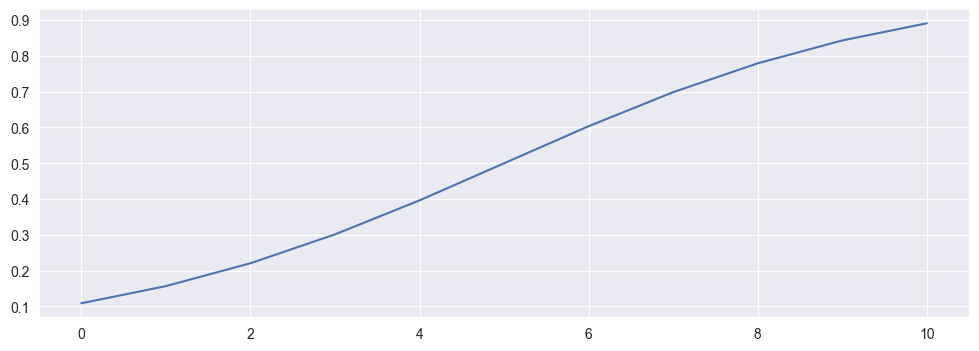

In [98]:
# perceptual training
# -----------------------------------------------------------------
n_perceptual_trials_per_color = 3
# states (colors coded by real probability of destroying the target)
sp = np.array(
    [np.linspace(0, 1, 10).round(1) for _ in range(n_perceptual_trials_per_color)]
    ).flatten()
# rewards (1 if target destroyed, 0 otherwise), using the real probabilities in s
rp = np.array(
    [np.random.binomial(1, sp[i]) for i in range(len(sp))]
    ).flatten()
# s.shape, r.shape

x = np.unique(sp*10)
y = h.get_p_destroy_full(sp*10, rp)

sns.lineplot(x, y)

In [100]:
# -----------------------------------------------------------------
# Full
# -----------------------------------------------------------------
# np.random.seed(0)

conditions = [
    [60, 40],
    [90, 10]
]
std = 5

n_trials_per_condition = 50
conditions_idx = np.repeat(np.arange(len(conditions)), n_trials_per_condition)
ff1 = np.random.randint(0, 11, n_trials_per_condition*2)
ff2 = np.random.randint(0, 11, n_trials_per_condition*2)

p_ff = np.linspace(0, 1, 11)

ntrials = len(conditions_idx)
hist_sp = list(sp*10)
hist_rp = list(rp)
# hist_rp = []
# hist_sp = []

df_list = []

nagents = 20

for agent in range(nagents):

    h = HybridModel(
            lr=.5,
            rl_temp=1,
            perceptual_temp=1,
            n_states=2,
            n_actions=2,
            q0=np.mean(conditions))

    for t in range(ntrials):

        s_rl = conditions_idx[t]

        sp1 = ff1[t]
        sp2 = ff2[t]
        
        a = h.make_choice(s_rl, hist_sp, hist_rp, sp1, sp2)

        r = np.random.normal(conditions[s_rl][a], std) 

        chosen_ff = sp1 if a == 0 else sp2
        unchosen_ff = sp2 if a == 0 else sp1

        destroyed = np.random.random() < p_ff[chosen_ff]
        
        if destroyed:
            h.rl_learn(s_rl, a, r)

        # add chosen ff to history
        hist_sp.append(chosen_ff)
        hist_rp.append(destroyed)
        
        #check that the model chose the best ff
        corr_ff = chosen_ff > unchosen_ff
        corr_rl = a == 0 

        unchosen = 1 if a == 0 else 0

        ev_chosen = conditions[s_rl][a] * p_ff[chosen_ff]
        ev_unchosen = conditions[s_rl][unchosen] * p_ff[unchosen_ff]

        df_list.append({
            'trial': t,
            'chosen_ff': chosen_ff,
            'unchosen_ff': unchosen_ff,
            'choice': a,
            'unchosen': unchosen,
            'correct_ff': corr_ff,
            'correct_rl': corr_rl,
            'correct_full':ev_chosen > ev_unchosen,
            'agent': agent
        })

df = pd.DataFrame(df_list)



Optimization terminated successfully.
         Current function value: 0.518008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.523872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516647
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532108
  

Text(0, 0.5, 'correct forcefield')

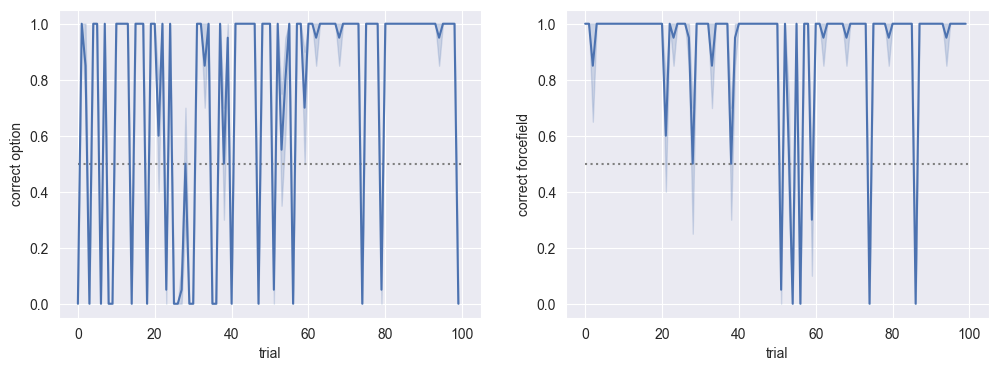

In [101]:
sns.set({'figure.figsize': (12, 4)})
plt.subplot(1, 2, 1)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_rl', data=df)
plt.ylabel('correct option')


plt.subplot(1, 2, 2)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_full', data=df)
plt.ylabel('correct forcefield')

